# Prediction Using LSTM

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
import datetime
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import pickle
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [39]:
file_loc = r'C:\Users\nkuma\Downloads\EE 798Q Endterm Project\Stock Market Data.csv'
stock_market_data = pd.read_csv(file_loc, index_col = 0, header = 0)

In [40]:
df = pd.DataFrame(stock_market_data)

In [41]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...
2021-04-26,14449.450200,14557.500000,14421.299810,14485.000000,14485.000000,452700.0
2021-04-27,14493.799810,14667.549810,14484.849610,14653.049810,14653.049810,451800.0
2021-04-28,14710.500000,14890.250000,14694.950200,14864.549810,14864.549810,457000.0


In [42]:
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')

In [43]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2021-04-16', '2021-04-19', '2021-04-20', '2021-04-22',
               '2021-04-23', '2021-04-26', '2021-04-27', '2021-04-28',
               '2021-04-29', '2021-04-30'],
              dtype='datetime64[ns]', name='Date', length=2694, freq=None)

<IPython.core.display.Javascript object>


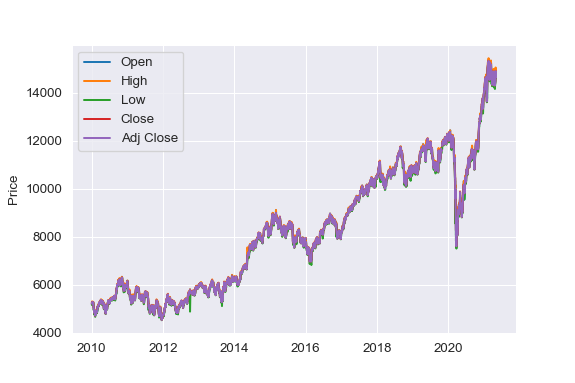

In [44]:
%matplotlib notebook
plt.plot(df.index, df['Open'], label = 'Open')
plt.plot(df.index, df['High'], label = 'High')
plt.plot(df.index, df['Low'], label = 'Low')
plt.plot(df.index, df['Close'], label = 'Close')
plt.plot(df.index, df['Adj Close'], label = 'Adj Close')
sns.set_style("darkgrid")
# plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

In [45]:
df.isna().sum()

Open         27
High         27
Low          27
Close        27
Adj Close    27
Volume       27
dtype: int64

Now I figured out that most of the rows which had NaN values were either weekend or market holiday.
So I dropped those rows.

First I dropped the rows of weekend

In [46]:
# df = df[df.index.weekday < 5]
# df

Dropping remaining weekdays which were market holiday

In [47]:
# df.drop(market_holidays, inplace = True)
# df

Now as all the columns are independent of each other and we need to predict only the closing prize of the stock so we keep only the close column in our data frame.

In [48]:
df = df[['Close']]
df

,Close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000
...,...
2021-04-26,14485.000000
2021-04-27,14653.049810
2021-04-28,14864.549810


In [49]:
df.isna().sum()

Close    27
dtype: int64

In [50]:
df_spline = df.interpolate(method = 'spline', order = 3)
df_cubic = df.interpolate(method = 'cubic')
df_linear = df.interpolate(method = 'linear')

In [51]:
df_final = pd.concat([df, df_linear, df_cubic, df_spline], axis=1)
df_final.columns = ['Close', 'Linear Interpolated', 'Cubic Interpolated', 'Spline Interpolated']
df_final

,Close,Linear Interpolated,Cubic Interpolated,Spline Interpolated
Date,,,,
2010-01-04,5232.200195,5232.200195,5232.200195,5232.200195
2010-01-05,5277.899902,5277.899902,5277.899902,5277.899902
2010-01-06,5281.799805,5281.799805,5281.799805,5281.799805
2010-01-07,5263.100098,5263.100098,5263.100098,5263.100098
2010-01-08,5244.750000,5244.750000,5244.750000,5244.750000
...,...,...,...,...
2021-04-26,14485.000000,14485.000000,14485.000000,14485.000000
2021-04-27,14653.049810,14653.049810,14653.049810,14653.049810
2021-04-28,14864.549810,14864.549810,14864.549810,14864.549810


<IPython.core.display.Javascript object>


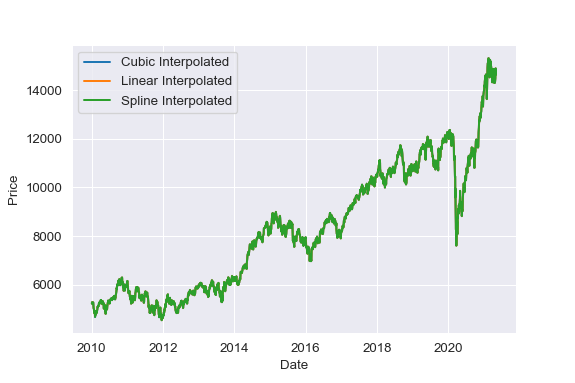

In [52]:
%matplotlib notebook
sns.lineplot(x = df_final.index, y = 'Cubic Interpolated', label = 'Cubic Interpolated', data = df_final)
sns.lineplot(x = df_final.index, y = 'Linear Interpolated', label = 'Linear Interpolated', data = df_final)
sns.lineplot(x = df_final.index, y = 'Spline Interpolated', label = 'Spline Interpolated', data = df_final)
plt.legend()
sns.set_style("darkgrid")
plt.ylabel('Price')
plt.show()

Cubic Interpolation is best

C:\Users\nkuma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


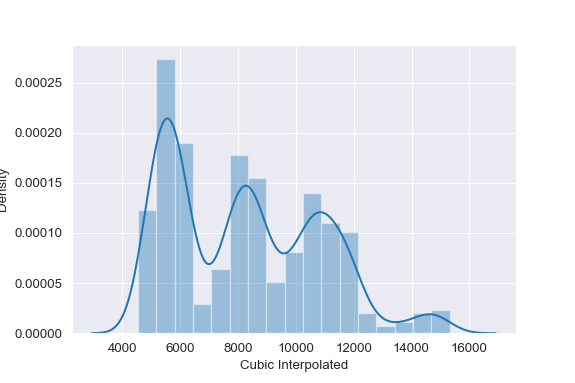

<AxesSubplot:xlabel='Cubic Interpolated', ylabel='Density'>

In [53]:
%matplotlib notebook
sns.distplot(df_final['Cubic Interpolated'])

Multimodal Distribution

In [54]:
df = df_final[['Cubic Interpolated']]
df.columns = ['Close']
df

,Close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000
...,...
2021-04-26,14485.000000
2021-04-27,14653.049810
2021-04-28,14864.549810


In [55]:
df.isna().sum()

Close    0
dtype: int64

Now we will scale our data between 0 and 1 as LSTM is sensitive to scale.

In [56]:
scaler = MinMaxScaler(feature_range = (0,1))
df_arr = scaler.fit_transform(df)
df_arr

array([[0.06387819],
       [0.06812123],
       [0.06848332],
       ...,
       [0.95820525],
       [0.96102318],
       [0.93653028]])

In [74]:
#splitting dataset into train and test split

training_size=int(len(df_arr)*0.70)
test_size=len(df_arr)-training_size
train_data,test_data=df_arr[:training_size,:],df_arr[training_size:len(df_arr),:1]

In [75]:
training_size, test_size

(1885, 809)

In [76]:
train_data.shape, test_data.shape

((1885, 1), (809, 1))

Defining a function which will split my data set into the number of feature on which my output depends and the output.
In this case we are give stock market data for previous 50 days and we have to predict for the next two days so my input feature will be 50 and output will be 1 then i will use recursive LSTM for the next days prediction.

In [77]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [78]:
# reshape into X=t,t+1,t+2,..., t+49 and Y=t+50
time_step = 50
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [79]:
x_train, y_train

(array([[0.06387819, 0.06812123, 0.06848332, ..., 0.05503921, 0.05428715,
         0.06071212],
        [0.06812123, 0.06848332, 0.06674712, ..., 0.05428715, 0.06071212,
         0.06671924],
        [0.06848332, 0.06674712, 0.06504339, ..., 0.06071212, 0.06671924,
         0.06137134],
        ...,
        [0.50711198, 0.5151896 , 0.51391297, ..., 0.53690174, 0.53833152,
         0.53893039],
        [0.5151896 , 0.51391297, 0.51459073, ..., 0.53833152, 0.53893039,
         0.54273246],
        [0.51391297, 0.51459073, 0.51447938, ..., 0.53893039, 0.54273246,
         0.54364696]]),
 array([0.06671924, 0.06137134, 0.06323751, ..., 0.54273246, 0.54364696,
        0.54092659]))

In [80]:
 x_train.shape, y_train.shape

((1834, 50), (1834,))

In [81]:
x_test.shape, y_test.shape

((758, 50), (758,))

Converting our data set to three dimesnional data which is required for LSTM

In [82]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [83]:
x_train.shape, x_test.shape

((1834, 50, 1), (758, 50, 1))

In [84]:
# conda install tensorflow

In [85]:
# conda install keras

In [86]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [87]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=0)

In [90]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

24/24 [==============================] - 0s 18ms/step


In [91]:
#Transforming back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [353]:
#Calcuating RMSE performance metric
rmse_train = sqrt(mean_squared_error(y_train,train_predict))
rmse_train

7915.790377359289

In [354]:
#Calculating RMSE performance metric for test data
rmse_test = sqrt(mean_squared_error(y_test,test_predict))
rmse_test

12040.608247538592

In [355]:
df_arr_inv = scaler.inverse_transform(df_arr)
df_arr_inv.shape

(2694, 1)

In [356]:
df_arr_inv.resize(2683,)
df_arr_inv.shape

(2683,)

In [357]:
type(train_predict), type(test_predict)

(numpy.ndarray, numpy.ndarray)

In [358]:
train_predict.resize(1961,) 
test_predict.resize(620,)
train_predict.shape, test_predict.shape

((1961,), (620,))

In [359]:
train_nan = np.full(len(df_arr_inv)-len(train_predict), np.nan)
test_nan = np.full(len(df_arr_inv)-len(test_predict), np.nan)
train_nan.shape, test_nan.shape

((722,), (2063,))

In [360]:
train_plot = np.concatenate((train_predict, train_nan))
test_plot = np.concatenate((test_nan, test_predict))
train_plot.shape, test_plot.shape

((2683,), (2683,))

In [361]:
# %matplotlib notebook
# plt.plot(df.index, df_arr_inv, label = 'Actual Closing Price')
# plt.plot(df.index, train_plot, label = 'Train Prediction')
# plt.plot(df.index, test_plot, label = 'Test Prediction')
# plt.ylabel('Price')
# plt.xlabel('Date')
# plt.legend()
# sns.set_style("darkgrid")
# plt.show()

In [362]:
# #Saving trained model
# LSTM_model = model
# with open('LSTM_model.pkl', 'wb') as file:
#     pickle.dump(LSTM_model, file)

In [92]:
model.save('model_4.h5')

In [93]:
file_loc = r'C:\Users\nkuma\Downloads\EE 798Q Endterm Project\Stock Market Data.csv'
stock_market_data = pd.read_csv(file_loc, index_col = 0, header = 0)

In [94]:
df = pd.DataFrame(stock_market_data)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...
2021-04-26,14449.450200,14557.500000,14421.299810,14485.000000,14485.000000,452700.0
2021-04-27,14493.799810,14667.549810,14484.849610,14653.049810,14653.049810,451800.0
2021-04-28,14710.500000,14890.250000,14694.950200,14864.549810,14864.549810,457000.0


In [95]:
df = df[['Close']]
df

,Close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000
...,...
2021-04-26,14485.000000
2021-04-27,14653.049810
2021-04-28,14864.549810


In [96]:
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')

In [97]:
df = df.interpolate(method = 'cubic')
df.isna().sum()

Close    0
dtype: int64

C:\Users\nkuma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


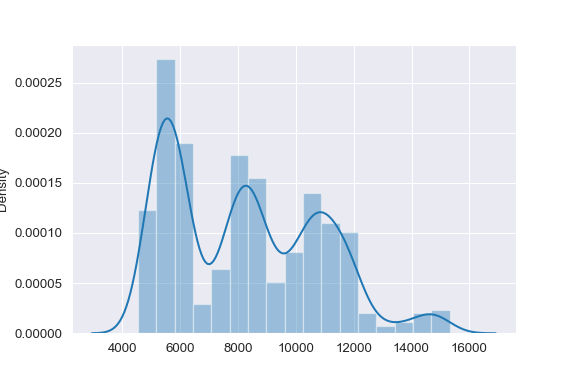

In [98]:
%matplotlib notebook
sns.distplot(df)
sns.set_style("darkgrid")

In [99]:
scaler = MinMaxScaler(feature_range = (0,1))
df_arr = scaler.fit_transform(df)
df_arr

array([[0.06387819],
       [0.06812123],
       [0.06848332],
       ...,
       [0.95820525],
       [0.96102318],
       [0.93653028]])

In [100]:
#splitting dataset into train and test split

training_size=int(len(df_arr)*0.80)
test_size=len(df_arr)-training_size
train_data,test_data=df_arr[:training_size,:],df_arr[training_size:len(df_arr),:1]

In [101]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [102]:
# reshape into X=t,t+1,t+2,..., t+49 and Y=t+50
time_step = 50
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [103]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation = 'tanh'))
model.compile(optimizer='adam', loss='mse')

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=0)

In [106]:
model.save('model_5.h5')

In [107]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences = True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences = False) )
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50, 50)            10400     
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=0, shuffle=False)

In [109]:
model.save('model_6.h5')